In [1]:
import numpy as np
import control as ct
import scipy.sparse as sparse
from scipy.sparse import coo_matrix, csr_matrix, diags, identity

from scipy.optimize import linprog

import matplotlib.pyplot as plt
import scripts.shadowban_pyoptsparse as sb
from scripts.shadowban_adaptive import *
from scripts.opinion_visualization import *
from scripts.opinion_data import *

import networkx as nx

import pandas as pd
import time
import seaborn as sns
from datetime import datetime

import json


C:\Users\trz2\Anaconda3\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


# Load Network

## Stochastic Blockmodel

In [84]:
nv = 1000
p0,p1 = 20/nv, 2/nv

nc = int(nv/2)
sizes = [nc, nc]

probs = [[p0, p1], [p1, p0]]
G = nx.DiGraph(nx.stochastic_block_model(sizes, probs, seed=0))

nv = G.number_of_nodes()
ne = G.number_of_edges()

for i in range(nc):
    rate = 1
    opinion0 = i/(nc-1)/2 
    opinion1 = 1-i/(nc-1)/2 
    G.nodes[i]['opinion'] = opinion0
    G.nodes[i+nc]['opinion'] = opinion1
  
                
rates = np.ones(nv)
opinions0 = np.array([G.nodes[v]["opinion"] for v in G.nodes()])

if nv<=100:
    colors = []
    for v in G.nodes():
        #print(f"{v}: {G.nodes[v]}")
        if (G.nodes[v]['opinion']<0.5) & (G.nodes[v]['opinion']>=0):
            colors.append('blue')
        elif (G.nodes[v]['opinion']>0.5) & (G.nodes[v]['opinion']<=1):
            colors.append('red')
        elif G.nodes[v]['opinion']==0.5:
            colors.append('purple')
        else:
            colors.append('green')
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize = (3,3))
    nx.draw(G,pos, node_color = colors, node_size = 50)

#adjacency matrix of network
A = nx.adjacency_matrix(G)
A = A.tocoo()
E0 = nx.incidence_matrix(G,oriented=True)
E0 = E0.tocoo()
ind = E0.data>0
E = coo_matrix((E0.data[ind], (E0.row[ind], E0.col[ind])), E0.shape)  #incidence matrix with only tail of edge

ne = G.number_of_edges()
#names of edges for shadowbanning in format uij
input_names = []
for e in G.edges():
    input_names.append(f"u{e[0]}{e[1]}")
#names of nodes opinions in format thetai
output_names = []
for v in G.nodes():
    output_names.append(f"theta{v}")
    
assert nv == A.shape[0]  #number of nodes in network should equal shape of A


#parameters of network model
network_params = {'A':A, 'E':E, 'rates':rates, 'opinions0':opinions0}



## Path Network

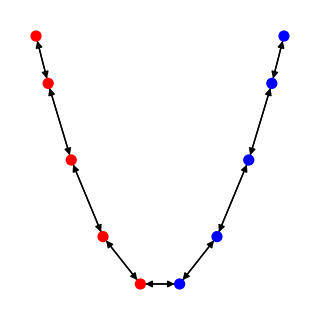

In [14]:
nv = 10

G = nx.DiGraph(nx.path_graph(nv))

nv = G.number_of_nodes()
ne = G.number_of_edges()

for i in range(nv):
    opinion0 = i/(nv-1) 
    G.nodes[i]['opinion'] = opinion0
  
                
rates = np.ones(nv)
opinions0 = np.array([G.nodes[v]["opinion"] for v in G.nodes()])

if nv<=100:
    colors = []
    for v in G.nodes():
        #print(f"{v}: {G.nodes[v]}")
        if (G.nodes[v]['opinion']<0.5) & (G.nodes[v]['opinion']>=0):
            colors.append('blue')
        elif (G.nodes[v]['opinion']>0.5) & (G.nodes[v]['opinion']<=1):
            colors.append('red')
        elif G.nodes[v]['opinion']==0.5:
            colors.append('purple')
        else:
            colors.append('green')
    pos = nx.spectral_layout(G)
    plt.figure(figsize = (3,3))
    nx.draw(G,pos, node_color = colors, node_size = 50)

#adjacency matrix of network
A = nx.adjacency_matrix(G)
A = A.tocoo()
E0 = nx.incidence_matrix(G,oriented=True)
E0 = E0.tocoo()
ind = E0.data>0
E = coo_matrix((E0.data[ind], (E0.row[ind], E0.col[ind])), E0.shape)  #incidence matrix with only tail of edge

ne = G.number_of_edges()
#names of edges for shadowbanning in format uij
input_names = []
for e in G.edges():
    input_names.append(f"u{e[0]}{e[1]}")
#names of nodes opinions in format thetai
output_names = []
for v in G.nodes():
    output_names.append(f"theta{v}")
    
assert nv == A.shape[0]  #number of nodes in network should equal shape of A


#parameters of network model
network_params = {'A':A, 'E':E, 'rates':rates, 'opinions0':opinions0}

#params = {'A':A,'E':E,'rates':rates,'tau':tau,'omega':omega, 'opinions0':opinions0,
#         'npts':npts,'smax':smax,'OBJECTIVE':OBJECTIVE}

## Twitter Network

1. US Election load time = 20.6 sec

2. Gilets Jaunes load time  13.2 sec


In [2]:
%%time
#network_params = load_us_election()
network_params = load_giletsjaunes()


Wall time: 16.3 s


# Simulation Parameters

In [3]:
#shift function parameters
tau = 0.1
omega = 0.1

#time discretization
npts = 24

#Upper limit of shadow ban strength
smax = 0.5
#Objective function
OBJECTIVE = 'MEAN'

sim_params = {'tau':tau,'omega':omega, 'npts':npts,'smax':smax,'OBJECTIVE':OBJECTIVE}

params = {**network_params, **sim_params}
nv = params['A'].shape[0]
ne = params['E'].shape[1]

print(f"Network has {nv:,} nodes, {ne:,} edges")

Network has 41,501 nodes, 2,257,716 edges


# Check Relaxation Time

You want the minimum relaxation time (which is greater than zero) to be greater than your simulation discretization time (which is one hour in our case).

1. US Election - relaxation time min = 7.3e-3  hours, 25% = 4.0  hours, 50% = 23.2 hours

2. Gilets Jaunes - relaxation time min = 5.1e-3 hours, 25% = 1.1 hours, 50% = 2.55 hours


In [4]:
relaxation_time_hrs = pd.Series(24/(params['omega']*params['rates']@params['A']))
relaxation_time_hrs[relaxation_time_hrs>0].describe()




C:\Users\trz2\AppData\Local\Temp\ipykernel_26184\3059222927.py:1: RuntimeWarning: divide by zero encountered in divide
  relaxation_time_hrs = pd.Series(24/(params['omega']*params['rates']@params['A']))
C:\Users\trz2\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


count    4.150100e+04
mean              inf
std               NaN
min      5.091708e-02
25%      1.069663e+01
50%      2.550000e+02
75%               NaN
max               inf
dtype: float64

# Simulate with No Shadow Banning

Runtimes for simulation with no shadow banning

1. US Presidential Election - 1 day = 8 min 40 s

2. Giles Jaunes - 1 day = 7min 9s

In [16]:
sys = ct.NonlinearIOSystem(
    updfcn =sb.sys_update, outfcn= None, states=nv,
    inputs=ne, outputs = nv,
    name='shadowban network', params=params)


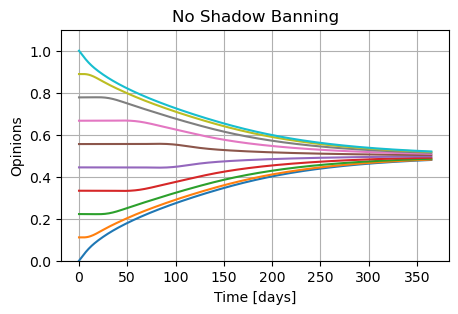

Wall time: 4.27 s


In [17]:
%%time
ndays = 365

T, Opinions_no_agent, _ = shadow_ban_fast(params, sys, ndays, False)
plt.figure(figsize = (5,3))
plot_opinions(T, Opinions_no_agent)
plt.xlabel("Time [days]")
plt.title("No Shadow Banning")
plt.show()

# Simulate With Shadow Banning

In [18]:
%%time
T, Opinions, U = shadow_ban_fast(params, sys, ndays)



Wall time: 4.01 s


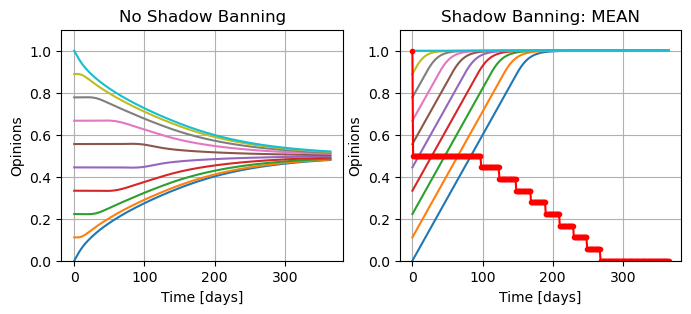

In [20]:
plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
plot_opinions(T, Opinions_no_agent)
plt.xlabel("Time [days]")
plt.title("No Shadow Banning")
plt.subplot(1,2,2)
plot_opinions(T, Opinions)
plt.plot(np.arange(0,ndays+1,1), 1-U, color = 'red',marker = '.',
         label = "Shadow Ban Strength")
#plt.legend()
plt.xlabel("Time [days]")
plt.title(f"Shadow Banning: {params['OBJECTIVE']}")

plt.show()

# Save results

In [43]:
# Specify the file path where you want to save the JSON file
file_path = f"data/results_sbm_test_{params['OBJECTIVE']}.json"


results = {'OBJECTIVE':params['OBJECTIVE'], 'tau':tau,'omega':omega,'smax':smax,'ndays':ndays,
           'Opinions_no_agent':Opinions_no_agent,'Opinions_shadowban':Opinions,'T':T, 'U':U}
results = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in results.items()}


# Open the file in write mode and save the dictionary as JSON
with open(file_path, "w") as json_file:
    json.dump(results, json_file)

# Load Results

In [37]:
with open(file_path, "r") as json_file:
    results = json.load(json_file)



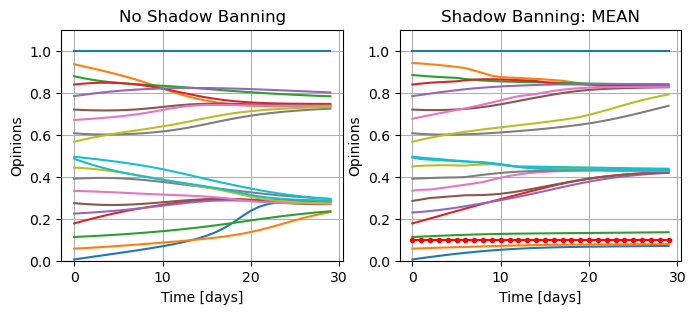

In [46]:
T =  results['T']
Opinions = np.array( results['Opinions_shadowban'])
U = np.array(results['U'])
Opinions_no_agent = np.array(results['Opinions_no_agent'])

plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
plot_opinions(T, Opinions_no_agent)
plt.xlabel("Time [days]")
plt.title("No Shadow Banning")
plt.subplot(1,2,2)
plot_opinions(T, Opinions)
plt.plot(np.arange(0,ndays,1), 1-U, color = 'red',marker = '.',
         label = "Shadow Ban Strength")
#plt.legend()
plt.xlabel("Time [days]")
plt.title(f"Shadow Banning: {params['OBJECTIVE']}")

plt.show()

# Run for all Objectives and Save

Results will be saved to data/results_path_10_nodes_365_days_MEAN.json


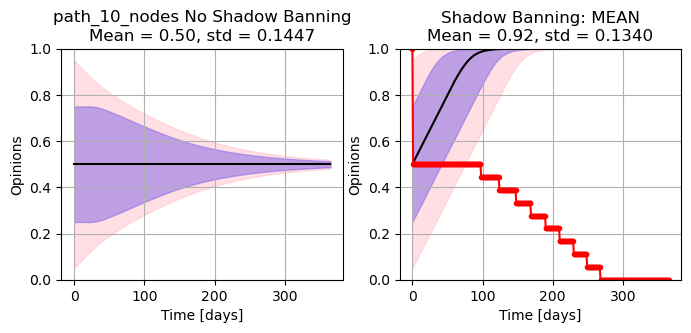

MEAN: Elapsed Time: 3.4 seconds
Results will be saved to data/results_path_10_nodes_365_days_VARMIN.json


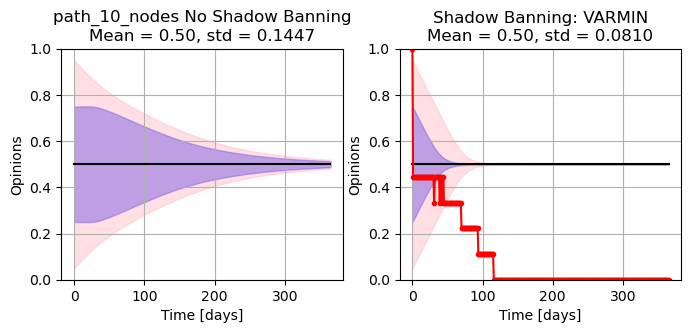

VARMIN: Elapsed Time: 5.1 seconds
Results will be saved to data/results_path_10_nodes_365_days_VARMAX.json


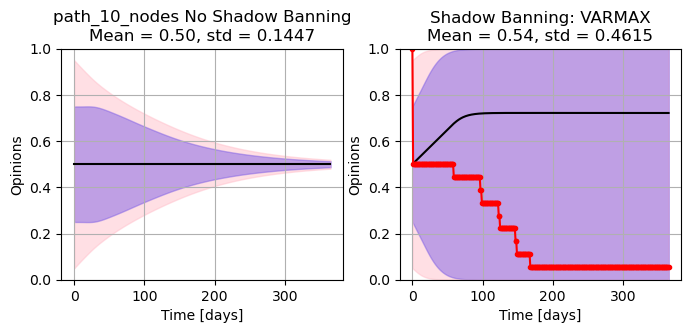

VARMAX: Elapsed Time: 5.2 seconds


In [22]:
ndays = 365
NETWORK = f'path_{nv}_nodes'
sys = ct.NonlinearIOSystem(updfcn =sb.sys_update, outfcn= None, states=nv,
                                inputs=ne, outputs = nv, name='shadowban network', params=params)
nv = params['A'].shape[0]
ne = params['E'].shape[1]

T, Opinions_no_agent, _ = shadow_ban_fast(params, sys, ndays, False)

for OBJECTIVE in ['MEAN','VARMIN','VARMAX']:
    start_time = time.time()  # Record the start time of each iteration

    params['OBJECTIVE']=OBJECTIVE
    T, Opinions, U = shadow_ban_fast(params, sys, ndays)
    # Specify the file path where you want to save the JSON file
    file_path = f"data/results_{NETWORK}_{ndays}_days_{params['OBJECTIVE']}.json"
    print(f"Results will be saved to {file_path}")

    results = {'OBJECTIVE':params['OBJECTIVE'], 'tau':tau,'omega':omega,'smax':smax,'ndays':ndays,
               'Opinions_no_agent':Opinions_no_agent,'Opinions_shadowban':Opinions,'T':T, 'U':U}
    results = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in results.items()}

    # Open the file in write mode and save the dictionary as JSON
    with open(file_path, "w") as json_file:
        json.dump(results, json_file)
    
    var_no_agent = Opinions_no_agent.var(axis=1).mean()
    var          = Opinions.var(axis=1).mean()
    mean_no_agent = Opinions_no_agent.mean(axis=1).mean()
    mean = Opinions.mean(axis=1).mean()
    std_no_agent = np.sqrt(var_no_agent)
    std = np.sqrt(var)
    
    plt.figure(figsize = (8,3))
    plt.subplot(1,2,1)
    plot_opinion_quantiles(T, Opinions_no_agent)
    plt.xlabel("Time [days]")
    plt.title(f"{NETWORK} No Shadow Banning\nMean = {mean_no_agent:.2f}, std = {std_no_agent:.4f}")
    plt.ylim([0,1])
    
    plt.subplot(1,2,2)
    plot_opinion_quantiles(T, Opinions)
    plt.plot(np.arange(0,ndays+1,1), 1-U, color = 'red',marker = '.',
             label = "Shadow Ban Strength")
    plt.xlabel("Time [days]")
    plt.title(f"Shadow Banning: {OBJECTIVE}\nMean = {mean:.2f}, std = {std:.4f}")
    plt.ylim([0,1])
    plt.show()
    
    end_time = time.time()  # Record the end time of each iteration
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    print(f"{params['OBJECTIVE']}: Elapsed Time: {elapsed_time:.1f} seconds")

# Load and Plot Results

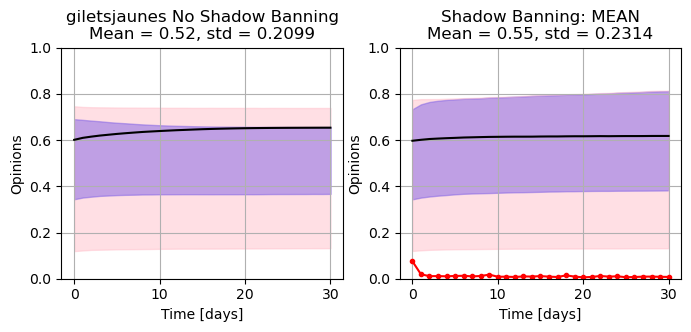

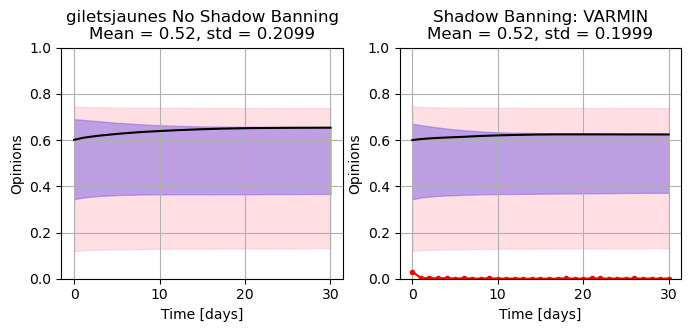

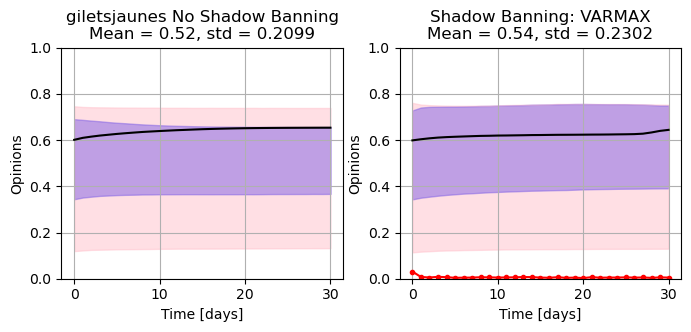

In [23]:
ndays = 31
NETWORK = 'giletsjaunes'
for OBJECTIVE in ['MEAN','VARMIN','VARMAX']:
    file_path = f"data/results_{NETWORK}_{ndays}_days_{OBJECTIVE}.json"
    with open(file_path, "r") as json_file:
        results = json.load(json_file)
    T =  results['T']
    Opinions = np.array( results['Opinions_shadowban'])
    U = np.array(results['U'])
    Opinions_no_agent = np.array(results['Opinions_no_agent'])

    var_no_agent = Opinions_no_agent.var(axis=1).mean()
    var          = Opinions.var(axis=1).mean()
    mean_no_agent = Opinions_no_agent.mean(axis=1).mean()
    mean = Opinions.mean(axis=1).mean()
    std_no_agent = np.sqrt(var_no_agent)
    std = np.sqrt(var)
    plt.figure(figsize = (8,3))
    plt.subplot(1,2,1)
    plot_opinion_quantiles(T, Opinions_no_agent)
    plt.xlabel("Time [days]")
    plt.title(f"{NETWORK} No Shadow Banning\nMean = {mean_no_agent:.2f}, std = {std_no_agent:.4f}")
    plt.ylim([0,1])
    plt.subplot(1,2,2)
    plot_opinion_quantiles(T, Opinions)
    plt.plot(np.arange(0,ndays,1), 1-U, color = 'red',marker = '.',
             label = "Shadow Ban Strength")
    #plt.legend()
    plt.xlabel("Time [days]")
    plt.title(f"Shadow Banning: {OBJECTIVE}\nMean = {mean:.2f}, std = {std:.4f}")
    plt.ylim([0,1])
    plt.show()

In [70]:
var_no_agent = Opinions_no_agent.mean(axis=1).mean()
var = Opinions.mean(axis=1).mean()
mean_no_agent = Opinions_no_agent.mean(axis=1).mean()
mean = Opinions.mean(axis=1).mean()